In [307]:
import pandas as pd
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras import regularizers
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
from string import punctuation
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split , cross_validate , GridSearchCV, cross_val_predict
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, plot_confusion_matrix
from nltk.corpus import stopwords as sw
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import  word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
pd.set_option ('display.max_colwidth', None)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [188]:
def mean_scores(results):
    '''Return Train/Test Mean Score from a Cross Val'''
    return print(f'''Mean Train Score: {results['train_score'].mean()}
Mean Test Score: {results['test_score'].mean()}''')

def metrics(y_true,y_preds):
    '''Gives recall,precision,accuracy,F1 score and confusion matrix'''
    return print(f'''Recall Score: {recall_score(y_true,y_preds,average='micro')}
Precision Score: {precision_score(y_true,y_preds,average='micro')}
Accuracy Score:{accuracy_score(y_true,y_preds)}
F1 Score: {f1_score(y_true,y_preds,average='micro')}
Confusion Matrix: 
{confusion_matrix(y_true,y_preds)}''')

def gs_mean_scores(results):
    '''Return Train and Test Scores from a grid search'''
    return print(f'''Mean Train Score: {results.cv_results_['mean_train_score'].mean()}'
Mean Test Score: {results.cv_results_['mean_test_score'].mean()}''')

def company_search(test):
    if test == 'iphone':
        return 'apple'
    elif test == 'apple':
        return 'apple'
    elif test == 'ipad':
        return 'apple'
    elif test == 'ipad or iphone app':
        return 'apple'
    elif test == 'itunes':
        return 'apple'
    elif test == 'other apple product or service':
        return 'apple'
    elif test == 'ios':
        return 'apple'
    elif test == 'ipadquot':
        return 'apple'
    elif test == 'applequot':
        return 'apple'
    elif test == 'iphonequot':
        return 'apple'
    elif test == 'quotiphone':
        return 'apple'
    elif test == 'iosquot':
        return 'apple'
    elif test =='quotipad':
        return 'apple'
    elif test == 'quotapple':
        return 'apple'
    elif test =='google':
        return 'google'
    elif test == 'android':
        return 'google'
    elif test == 'other google product or service':
        return 'google'
    elif test == 'android app':
        return 'google'
    elif test == 'quotgoogle':
        return 'google'
    elif test == 'googlequot':
        return 'google'
    elif test == 'androidquot':
        return 'google'
    else:
        return 'unknown'

# EDA and Pre Processing

In [195]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',encoding='latin1')
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

There are 5802 missing values telling what the tweet is directed at. A way to combat this would be to look at the tweet and look for keywords such as iphone or ipad and assign who it is directed to that way.

In [196]:
#We drop the 1 NA value from our dataset
df = df.dropna(subset=['tweet_text'])

In [197]:
#Take out puncuation and other unnecessary characters
df['tweet_text'] = df['tweet_text'].str.replace(r'[^\w\s]', '')
df['tweet_text'] = df['tweet_text'].str.replace('quot', '')
# Make lower case and split
df['tweet_text'] = df['tweet_text'].str.lower()

In [198]:
snbstem = SnowballStemmer('english')
df['lem_text'] = df['tweet_text'].apply(lambda x: [snbstem.stem(x)])

In [199]:
df['tweet_text'] = df['tweet_text'].str.split(' ')

Here we do some basic cleaning of the data set, removing puncuation making everything lower case and splitting the data. We also use snowball stemmer.

In [201]:
# Make a blank column to set up for some data cleaning
df['test'] = ''
# Fill in the values with a string na to avoid errors
df.fillna('na',inplace=True)

In [202]:
# This salvages alot of our data

apple = ['iphone','ipad','apple','apples','ipads']
android = ['android','google','androids','googles']

# Loop through the tweet column and look for keywords to assign product to
for ind , val in enumerate(df['tweet_text']):
    if df['emotion_in_tweet_is_directed_at'].values[ind] == 'na':
        for y in val:
            if y in apple:
                df['test'].values[ind] = y
            elif y in android:
                df['test'].values[ind] = y
                
    else:
        df['test'].values[ind] = df['emotion_in_tweet_is_directed_at'].values[ind]

For this process, we looped over the tweets themselves to see if we could determine what product or company the tweet was above.

In [203]:
len(df.loc[df['test'] == ''])

915

We managed to fill in 4886 rows of missing data with our for loop.

In [204]:
#make everything lower case to make values match
df['test'] = df['test'].map(lambda x : x.lower())
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service', '',
       'googles', 'ipads', 'apples', 'other apple product or service',
       'androids'], dtype=object)

In [205]:
#This cell replaces words with the rightful product to reduce unique values
df['test'] = df['test'].replace({'googles': 'google', 'apples': 'apple', 'androids': 'android','ipads':'ipad'})


In [206]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

Looking at the target of our dataset, there seems to be four different values. Negative emotion, positive emotion, no emotion and I can't tell. Let's get a closer look at these 'I can't tell' labels.

In [207]:
len(df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"])

156

Since this makes up such a small amount of our data, we will move the I can't tell value to that of neutral, along with the value 'No emotion toward brand or product'.

In [208]:
# Here we make change targets into more readable text
emotion_dict = {'No emotion toward brand or product' : 'Neutral emotion', "I can't tell": 'Neutral emotion', 'Positive emotion': 'Positive emotion',
               'Negative emotion': 'Negative emotion'}
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(emotion_dict)

In [209]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()

array(['Negative emotion', 'Positive emotion', 'Neutral emotion'],
      dtype=object)

We have now turned our dataset into a ternary classification set. With this we will now begin our modeling.

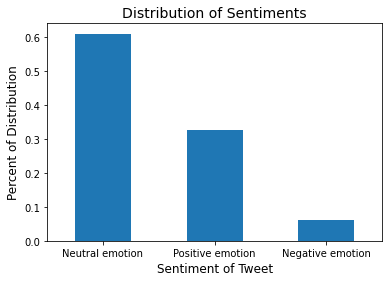

In [305]:
df_dist = df.groupby('is_there_an_emotion_directed_at_a_brand_or_product').count()
fig ,ax = plt.subplots()
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True).plot.bar()

plt.xticks(rotation=0,fontsize=10)
ax.set_xlabel('Sentiment of Tweet',fontsize=12)
ax.set_ylabel('Percent of Distribution',fontsize=12)
ax.set_title('Distribution of Sentiments',fontsize=14);

# Testing

In [217]:
# Map out our values to prepare for modeling
target_dict = {'Negative emotion': 2, 'Neutral emotion': 1, 'Positive emotion': 0}
df_test = df.copy()
df_test['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(target_dict)

In [218]:
X = df_test['lem_text'].str.join(' ')
y = df_test['target']

In [219]:
# Make Our test and train set
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [220]:
# Our first model we will try a CountVectorizer with Naive Bayes
cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_train)
X_t_vec = cv.fit_transform(X_train)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_train.index, inplace=True)

In [221]:
mnb = MultinomialNB()

In [222]:
mnb.fit(X_t_vec,y_train)
results = cross_validate(mnb,X_t_vec,y_train,return_train_score=True)

In [223]:
mean_scores(results)

Mean Train Score: 0.8341765135163467
Mean Test Score: 0.6630004754907128


From our first look at the model, it seems to be overfit. It has high variance from our test and train scores.

In [224]:
y_hat = cross_val_predict(mnb,X_t_vec,y_train)
metrics(y_train,y_hat)

Recall Score: 0.6630004399472064
Precision Score: 0.6630004399472064
Accuracy Score:0.6630004399472064
F1 Score: 0.6630004399472064
Confusion Matrix: 
[[1274  989   10]
 [ 854 3199   55]
 [ 170  220   48]]


This model doesn't do a great job at predicting negative sentiments. Let's look at other models to see what we can find.

In [225]:

lr_pipe = Pipeline([("vec" , CountVectorizer(stop_words=sw.words('english'))),
                       ("lr",LogisticRegression(C=.5,solver='saga'))])
results_LR = cross_validate(lr_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_LR)

Mean Train Score: 0.8971621786894103
Mean Test Score: 0.6918886878392713


This scores better than our first model.

In [226]:
y_hat_lr = cross_val_predict(lr_pipe, X_train, y_train)
metrics(y_train,y_hat_lr)

Recall Score: 0.6917436574277753
Precision Score: 0.6917436574277753
Accuracy Score:0.6917436574277753
F1 Score: 0.6917436574277753
Confusion Matrix: 
[[1157 1097   19]
 [ 593 3461   54]
 [  93  246   99]]


This model seems to do a better job at predictin the negative sentiment, but lost some positive snentiments. This is a better model than our first one.

In [227]:
#Here we try a TFIDFVectorizer with MNB
pipe_tf = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')), MultinomialNB())
cv = cross_validate(pipe, X_train, y_train,return_train_score=True)

In [228]:
mean_scores(cv)

Mean Train Score: 0.9961138050323763
Mean Test Score: 0.676491394909022


This is our worst model yet

In [229]:
y_hat_tf = cross_val_predict(pipe_tf, X_train, y_train)
metrics(y_train,y_hat_tf)

Recall Score: 0.649068778413257
Precision Score: 0.649068778413257
Accuracy Score:0.649068778413257
F1 Score: 0.649068778413257
Confusion Matrix: 
[[ 490 1783    0]
 [ 172 3935    1]
 [  44  393    1]]


This model cannot predict any negatives at all. 

In [230]:
pipe_rf = make_pipeline(TfidfVectorizer(stop_words=sw.words('english')), RandomForestClassifier())
cv = cross_validate(pipe_rf, X_train, y_train,return_train_score=True)
mean_scores(cv)

Mean Train Score: 0.996150468643742
Mean Test Score: 0.6773713754590852


In [232]:
y_hat_rf = cross_val_predict(pipe_rf, X_train, y_train)
metrics(y_train,y_hat_rf)

Recall Score: 0.6776653468250476
Precision Score: 0.6776653468250476
Accuracy Score:0.6776653468250476
F1 Score: 0.6776653468250476
Confusion Matrix: 
[[ 898 1372    3]
 [ 423 3651   34]
 [  66  300   72]]


Nothing too special about this model, it is not the highest scoring and does a decent job of classifying negatives.

In [233]:
lr_pipe = Pipeline([("tfid" , TfidfVectorizer(stop_words='english')),
                       ("lr",LogisticRegression())])
results_LR = cross_validate(lr_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_LR)

Mean Train Score: 0.8246809943257416
Mean Test Score: 0.6847026461811211


In [234]:
y_hat_lr = cross_val_predict(lr_pipe,X_train,y_train)
metrics(y_train,y_hat_lr)

Recall Score: 0.6847045021264115
Precision Score: 0.6847045021264115
Accuracy Score:0.6847045021264115
F1 Score: 0.6847045021264115
Confusion Matrix: 
[[1046 1223    4]
 [ 502 3595   11]
 [  99  311   28]]


Althought this does give a good accuracy score, the negative classifying isn't quire there. This model does the best overall at accuracy though. Let's tune some hyper parameters.

In [235]:
lr_grid = {'lr__C' : [.5, 1, 50],
       'lr__max_iter' : [50,100,1750, 2000],
       }

clf_lr = GridSearchCV(lr_pipe,lr_grid,return_train_score=True)

In [236]:
lr_results = clf_lr.fit(X_train,y_train)
gs_mean_scores(lr_results)

Mean Train Score: 0.8506531971350055'
Mean Test Score: 0.6773342613649812


In [237]:
clf_lr.best_params_


{'lr__C': 1, 'lr__max_iter': 100}

In [238]:
lr_pipe2 = Pipeline([("tfid" , TfidfVectorizer(stop_words='english')),
                       ("lr",LogisticRegression(max_iter=50))])
results_LR = cross_validate(lr_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_LR)

Mean Train Score: 0.8246809943257416
Mean Test Score: 0.6847026461811211


In [239]:
y_preds = cross_val_predict(lr_pipe2,X_train,y_train)
metrics(y_train,y_preds)

Recall Score: 0.6835313095761842
Precision Score: 0.6835313095761842
Accuracy Score:0.6835313095761842
F1 Score: 0.6835313095761842
Confusion Matrix: 
[[1042 1227    4]
 [ 502 3593   13]
 [  98  314   26]]


This model performs well but is still struggling with the negative classification.

In [240]:
svc_pipe = Pipeline([("tfid" , TfidfVectorizer(stop_words=sw.words('english'))),
                     ("svc", SVC())])
results_svc = cross_validate(svc_pipe,X_train,y_train,return_train_score=True)
mean_scores(results_svc)

Mean Train Score: 0.9137336740755474
Mean Test Score: 0.6932087662414503


In [83]:
y_svc = cross_val_predict(svc_pipe,X_train,y_train)
metrics(y_train,y_svc)

Recall Score: 0.6932101481155595
Precision Score: 0.6932101481155595
Accuracy Score:0.6932101481155595
F1 Score: 0.6932101481155595
Confusion Matrix: 
[[ 885 1340    1]
 [ 363 3806   10]
 [  47  331   36]]


In [346]:
y_nn = df_test['target']
x_nn = df_test['tweet_text']

In [347]:
model_nn = Sequential()
model_nn.add(Embedding(7000, 100))
model_nn.add(LSTM(25))
model_nn.add(Dense(50, activation='relu'))
model_nn.add(Dense(3, activation='relu'))

In [348]:
text_t = text.Tokenizer(num_words=7000)
text_t.fit_on_texts((x_nn))
list_tt = text_t.texts_to_sequences(x_nn)
x_nn = sequence.pad_sequences(list_tt)

In [349]:
model_nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_nn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         700000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 25)                12600     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 153       
Total params: 714,053
Trainable params: 714,053
Non-trainable params: 0
_________________________________________________________________


In [352]:
results = model_nn.fit(x_nn, y_nn, epochs=100)

Epoch 1/100
285/285 [==============================] - 2s 8ms/step - loss: -0.7227 - accuracy: 0.3781
Epoch 2/100
285/285 [==============================] - 2s 8ms/step - loss: -0.7254 - accuracy: 0.4706
Epoch 3/100
285/285 [==============================] - 2s 8ms/step - loss: -0.7263 - accuracy: 0.5365
Epoch 4/100
285/285 [==============================] - 2s 8ms/step - loss: -0.7067 - accuracy: 0.4480
Epoch 5/100
285/285 [==============================] - 2s 8ms/step - loss: -0.6903 - accuracy: 0.3299
Epoch 6/100
285/285 [==============================] - 2s 8ms/step - loss: -0.7320 - accuracy: 0.3303
Epoch 7/100
285/285 [==============================] - 2s 8ms/step - loss: -0.7292 - accuracy: 0.3894
Epoch 8/100
285/285 [==============================] - 2s 8ms/step - loss: -0.7408 - accuracy: 0.4655
Epoch 9/100
285/285 [==============================] - 2s 8ms/step - loss: -0.7318 - accuracy: 0.5223
Epoch 10/100
285/285 [==============================] - 2s 8ms/step - loss: -0.742

In [360]:
score = model_nn.evaluate(x_nn, y_nn, verbose=0)
score

[-0.7746095061302185, 0.5589529275894165]

In [342]:
text_t = text.Tokenizer(num_words=7000)
text_t.fit_on_texts((x_nn))
list_tt = text_t.texts_to_sequences(x_nn)
x_nn = sequence.pad_sequences(list_tt)

In [343]:
model_nn2.add(Embedding(7000, 15))
model_nn2.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model_nn2.add(LSTM(15))
model_nn2.add(Dropout(0.5))
model_nn2.add(Dense(3, activation='sigmoid'))
model_nn2.add(Dropout(0.5))
model_nn2.add(Dense(1, activation='relu'))

In [344]:
model_nn2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_nn2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 15)          105000    
_________________________________________________________________
dense_15 (Dense)             (None, None, 10)          160       
_________________________________________________________________
lstm_6 (LSTM)                (None, 15)                1560      
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 48        
_________________________________________________________________
dropout_7 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [345]:
model_nn2.fit(x_nn, y_nn, epochs=30, batch_size=256, validation_split=0.3)

Epoch 1/30
25/25 [==============================] - 1s 27ms/step - loss: 11.5362 - accuracy: 0.3311 - val_loss: 11.4501 - val_accuracy: 0.3193
Epoch 2/30
25/25 [==============================] - 0s 12ms/step - loss: 11.5185 - accuracy: 0.3311 - val_loss: 11.4329 - val_accuracy: 0.3193
Epoch 3/30
25/25 [==============================] - 0s 11ms/step - loss: 11.5018 - accuracy: 0.3311 - val_loss: 11.4168 - val_accuracy: 0.3193
Epoch 4/30
25/25 [==============================] - 0s 11ms/step - loss: 11.4862 - accuracy: 0.3311 - val_loss: 11.4017 - val_accuracy: 0.3193
Epoch 5/30
25/25 [==============================] - 0s 11ms/step - loss: 11.4719 - accuracy: 0.3311 - val_loss: 11.3880 - val_accuracy: 0.3193
Epoch 6/30
25/25 [==============================] - 0s 11ms/step - loss: 11.4585 - accuracy: 0.3311 - val_loss: 11.3750 - val_accuracy: 0.3193
Epoch 7/30
25/25 [==============================] - 0s 11ms/step - loss: 11.4458 - accuracy: 0.3311 - val_loss: 11.3628 - val_accuracy: 0.3193

This model gives us high accuracy but still struggles with negative tweets, let us try some hyperparameter tuning.

In [84]:
svc_params = {'svc__C': [1,2,3,4,5],
             'svc__kernel':['linear','rbf','sigmoid','poly'],
              'svc__degree':[3,5,7,8],
             }

svc_gs = GridSearchCV(estimator=svc_pipe, param_grid=svc_params, return_train_score=True)

In [86]:
gs_results = svc_gs.fit(X_train,y_train)

In [88]:
svc_gs.best_params_

{'svc__C': 2, 'svc__degree': 3, 'svc__kernel': 'rbf'}

GridSearch has determined these are our best parameters, so let's rerun the model with these to see what we get.

In [259]:
svc_pipe2 = Pipeline([("tfid" , TfidfVectorizer(stop_words=sw.words('english'))),
                     ("svc", SVC(C=2,kernel='rbf',degree=3))])
results_svc = cross_validate(svc_pipe2,X_train,y_train,return_train_score=True)
mean_scores(results_svc)

Mean Train Score: 0.9565918834720761
Mean Test Score: 0.6917429208899637


In [260]:
y_svc2 = cross_val_predict(svc_pipe2,X_train,y_train)
metrics(y_train,y_svc2)

Recall Score: 0.6917436574277753
Precision Score: 0.6917436574277753
Accuracy Score:0.6917436574277753
F1 Score: 0.6917436574277753
Confusion Matrix: 
[[1143 1123    7]
 [ 576 3488   44]
 [  79  273   86]]


This model gives the highest accuracy and does the best job at classifying negative sentiments. We will choose this as our final model.

# Final Model - TFIDVectorizer with SVC Classifier

In [261]:
svc_pipe2.fit(X_train,y_train)
svc_pipe2.score(X_test,y_test)

0.7003959524857017

This gives us a 70% accuracy on our test set.

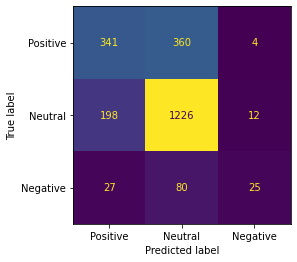

In [263]:
plot_confusion_matrix(svc_pipe2,X_test,y_test,display_labels=['Positive','Neutral','Negative'],colorbar=False);

Our model needs improvement on finding negative sentiments. This would help if we had more negative tweets to go off of.

## Visualizations

##### Seperate Dataframes by company

In [ ]:
df_apple = df.loc[df['company'] == 'apple']
df_google = df.loc[df['company'] == 'google']

######  Chart displaying total sweets by sentiment for each company

In [ ]:
plt.figure(figsize=(15, 12))

sns.set_style('darkgrid')


ax1 = plt.subplot2grid(shape=(2,5), loc = (0,0))
ax2 = plt.subplot2grid(shape=(2,5), loc = (0,1),)

sns.barplot(x = df_apple['Emotion'].value_counts().index,
           y = df_apple['Emotion'].value_counts().values,
           ax =ax1)
ax1.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax1.set_title('Apple')
ax1.set_ylim(0,3000)

sns.barplot(x = df_google['Emotion'].value_counts().index,
           y = df_google['Emotion'].value_counts().values,
           ax = ax2)
ax2.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax2.set_title('Google')
ax2.set_ylim(0,3000)
ax2.set(yticklabels = []);

##### Chart showing distribution of tweet sentiment by category of item tweeted about

In [ ]:
cat_dict = {'iphone' : 'Phone/iPad', 'android': 'Phone/iPad', 'ipad': 'Phone/iPad', 'apple':'Platform',
'google':'Platform', 'ipad or iphone app': 'App', 'android app': 'App', 'other google product or service' : 'Other product/service',
'other apple product or service': 'Other product/service', 'ios': 'Other product/service', 'itunes': 'Other product/service'}
df['category'] = df['test'].map(cat_dict)

In [ ]:
plt.figure(figsize=(20,14))

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,4), loc=(1,1))

sns.barplot(x = df.loc[df.category == 'Phone/iPad']['target'].value_counts().index,
               y = df.loc[df.category == 'Phone/iPad']['target'].value_counts(normalize=True),
           ax=ax1)
ax1.set_title('Phone/iPad')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.category == 'Platform']['target'].value_counts().index,
            y = df.loc[df.category == 'Platform']['target'].value_counts(normalize=True),
           ax=ax2)
ax2.set_title('Platform')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.category == 'App']['target'].value_counts().index,
               y = df.loc[df.category == 'App']['target'].value_counts(normalize=True),
           ax=ax3)
ax3.set_title('App-Related')
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Frequency')
ax3.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.category == 'Other product/service']['target'].value_counts().index,
               y = df.loc[df.category == 'Other product/service']['target'].value_counts(normalize=True),
           ax=ax4)
ax4.set_title('Other Products/Services')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Frequency')
ax4.set_xticklabels(['Negative', 'Neutral', 'Positive']);

### Tfidf Exploration

In [1]:
raw_pos = []
raw_neg = []
raw_neu = []

pos_tweets = df_test.loc[df.target==2]
pos_tweets

neg_tweets = df_test.loc[df.target==0]

neutral_tweets = df_test.loc[df.target==1]

for listx in pos_tweets.clean_tweet:
    for x in listx:
        raw_pos.append(x)
    
for listx in neg_tweets.clean_tweet:
    for x in listx:
        raw_neg.append(x)
        
for listx in neutral_tweets.clean_tweet:
    for x in listx:
        raw_neu.append(x)
        
raw_pos = ' '.join(raw_pos)
raw_neg = ' '.join(raw_neg)
raw_neu = ' '.join(raw_neu)

NameError: name 'df_test' is not defined

In [ ]:
top_poswords = dict(df_topwords.loc[['positive']].max().sort_values(ascending=False)[:150])
top_negwords = dict(df_topwords.loc[['negative']].max().sort_values(ascending=False)[:100])